In [ ]:
# %pip install kaggle kagglehub openpyxl transformers --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [10]:
path = kagglehub.dataset_download("fatmamtalaat/wellness-dataset-dr-fatma-m-talaat")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Josue\.cache\kagglehub\datasets\fatmamtalaat\wellness-dataset-dr-fatma-m-talaat\versions\1


In [11]:
excel_path = os.path.join(path, "Wellness Dataset - Dr.Fatma M. Talaat.xlsx")
df = pd.read_excel(excel_path)
df.head()

,Duration of Sleep (hours),Level of Physical Activity (minutes per day),Level of Stress (scale: 1–10),BMI Category,Heart Rate (bpm),Systolic and Diastolic Blood Pressure,"Nutrition Intake (calories, breakdown of nutrients, etc.)",Level of Workload (scale: 1–10),Quality or frequency of social interactions,Activities for Mental Health (such as therapy sessions or meditation),Environmental Aspects (such as weather and air quality),Lifestyle Decisions (such as drinking and smoking),"Additional health indicators (e.g., water levels, steps)",Mood Output
0,7.5,30,5,Normal,72,120/80,2000 calories (balanced diet),6,"Good, frequent",Meditation daily,"Sunny, good air quality","No alcohol, no smoking","2 liters, 10,000 steps",Happy
1,6.8,45,3,Overweight,75,118/78,2500 calories (high in carbs),7,"Moderate, occasional",NaN,"Rainy, poor air quality","Occasional alcohol, no smoking","1.5 liters, 8000 steps",Neutral
2,8.2,15,8,Underweight,68,115/75,1800 calories (low in protein),9,"Low, infrequent",Therapy sessions weekly,"Sunny, good air quality","No alcohol, no smoking","2.5 liters, 5000 steps",Sad
3,7.0,60,4,Normal,70,122/82,2200 calories (healthy diet),5,"Very good, daily",Yoga twice a week,"Cloudy, moderate air quality","No alcohol, no smoking","2 liters, 12000 steps",Happy
4,5.5,10,9,Obese,80,130/90,3000 calories (unhealthy),10,"Poor, infrequent",NaN,"Sunny, good air quality","Daily alcohol, occasional smoking","1 liter, 3000 steps",Sad


In [12]:
print(df.columns.tolist())


['Duration of Sleep (hours)', 'Level of Physical Activity (minutes per day)', 'Level of Stress (scale: 1–10)', 'BMI Category', 'Heart Rate (bpm)', 'Systolic and Diastolic Blood Pressure', 'Nutrition Intake (calories, breakdown of nutrients, etc.)', 'Level of Workload (scale: 1–10)', 'Quality or frequency of social interactions', 'Activities for Mental Health (such as therapy sessions or meditation)', 'Environmental Aspects (such as weather and air quality)', 'Lifestyle Decisions (such as drinking and smoking)', 'Additional health indicators (e.g., water levels, steps)', 'Mood Output']


In [13]:
# Clean column names: lowercase, underscores, remove punctuation
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
    .str.replace(r"\s+", "_", regex=True)
)

print(df.columns.tolist())


['duration_of_sleep_hours', 'level_of_physical_activity_minutes_per_day', 'level_of_stress_scale_110', 'bmi_category', 'heart_rate_bpm', 'systolic_and_diastolic_blood_pressure', 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'level_of_workload_scale_110', 'quality_or_frequency_of_social_interactions', 'activities_for_mental_health_such_as_therapy_sessions_or_meditation', 'environmental_aspects_such_as_weather_and_air_quality', 'lifestyle_decisions_such_as_drinking_and_smoking', 'additional_health_indicators_eg_water_levels_steps', 'mood_output']


In [14]:
def extract_steps(text):
    indicator = text
    try:
        steps_text = indicator.split(',', 1)[-1].strip()  # Get last part like "10,000 steps"
        steps_number = int(steps_text.split(" ")[0].replace(',', ''))  # Remove comma and convert to int
        return steps_number
    except (IndexError, ValueError, AttributeError):
        return 0

df['extracted_steps'] = df['additional_health_indicators_eg_water_levels_steps'].apply(extract_steps)

In [15]:
# Correlation Matrix
if 'mood_output' in df.columns:
    if df['mood_output'].dtype == 'object':
        le = LabelEncoder()
        df['mood_output_encoded'] = le.fit_transform(df['mood_output'])
        target_col = 'mood_output_encoded'
    else:
        target_col = 'mood_output'

    numeric_df = df.select_dtypes(include='number')
    corr_matrix = numeric_df.corr()[target_col].sort_values(ascending=False)
    print(corr_matrix)
else:
    print("Column 'mood_output' not found.")


mood_output_encoded                           1.000000
level_of_workload_scale_110                   0.879303
level_of_stress_scale_110                     0.836217
heart_rate_bpm                                0.552565
level_of_physical_activity_minutes_per_day   -0.278266
duration_of_sleep_hours                      -0.529095
extracted_steps                              -0.549012
Name: mood_output_encoded, dtype: float64


## 1. Demographic Health Grouping

In [16]:
def calculate_bmi(weight_lbs, height_in):
    # Helper function to calculate BMI
    weight_kg = weight_lbs / 2.20462
    height_m = height_in * 2.54 / 100
    return weight_kg / (height_m ** 2)

def get_recommended_calories(age, gender, activity_minutes):
    # Helper function to get recommended daily calorie intake
    if gender.lower() == 'male':
        if age < 30:
            base = 2500
        elif age < 50:
            base = 2400
        else:
            base = 2200
    else:  # female
        if age < 30:
            base = 2000
        elif age < 50:
            base = 1900
        else:
            base = 1800

    # Adjust based on activity level
    if activity_minutes >= 60:
        adjustment = 200  # active
    elif activity_minutes >= 30:
        adjustment = 100  # moderately active
    else:
        adjustment = 0  # sedentary

    return base + adjustment

# Function to classify demographic grouping based on minutes of activity/steps
def classify_demographic_grouping(row, height_in="", weight_lbs="", age = 25, gender = 'female'):
    activity_minutes = float(row.get('level_of_physical_activity_minutes_per_day', 20))

    nutrition_intake = 0

    try:
        nutrition_text = row['nutrition_intake_calories_breakdown_of_nutrients_etc']
        match = re.search(r"(\d+)\s*[cC]alories", nutrition_text)
        if match:
            calories = int(match.group(1))
            # print("Calories:", calories)
            nutrition_intake = calories
        else:
            raise ValueError("Calories cannnot be read.")
        # nutrition_intake = float(row['nutrition_intake_calories_breakdown_of_nutrients_etc'])
    except (ValueError, TypeError,AttributeError, IndexError):
        return 'NEUTRAL_CONSUMPTION'

    try:
        if height_in and weight_lbs:
            bmi = calculate_bmi(float(weight_lbs), float(height_in))
        else:
            category = str(row.get('bmi_category', 'normal')).lower()
            bmi_values = {'underweight': 17, 'normal': 22, 'overweight': 27, 'obese': 32}
            bmi = bmi_values.get(category, 22)
    except (ValueError, TypeError):
        bmi = 22

    if bmi < 18.5:
        bmi_category = 'underweight'
    elif 25 <= bmi < 30:
        bmi_category = 'overweight'
    elif bmi >= 30:
        bmi_category = 'obese'
    else:
        bmi_category = 'normal'

    factor = {'underweight': 1.25, 'normal': 1.0, 'overweight': 0.7, 'obese': 0.7}[bmi_category]
    recommended = get_recommended_calories(age, gender, activity_minutes)
    target = recommended * factor

    if abs(nutrition_intake - target) <= 200:
        return 'HEALTHY_CONSUMPTION'
    elif abs(nutrition_intake - target) <= 400:
        return 'NEUTRAL_CONSUMPTION'
    else:
        return 'UNHEALTHY_CONSUMPTION'

# Apply classification to the dataset
df['demographic_health_grouping'] = df.apply(lambda row: classify_demographic_grouping(
        row),
    axis=1)

print(df['demographic_health_grouping'].value_counts())


demographic_health_grouping
UNHEALTHY_CONSUMPTION    440
HEALTHY_CONSUMPTION      261
NEUTRAL_CONSUMPTION       36
Name: count, dtype: int64


## 2. Lifestyle Grouping

In [17]:
def classify_lifestyle_grouping(row, age_group='adult'):
    sleep_hours = row['duration_of_sleep_hours']
    heart_rate = row['heart_rate_bpm']
    blood_pressure = row['systolic_and_diastolic_blood_pressure']

    # Define good sleep ranges by age group
    sleep_ranges = {
        'adult': (7, 9),
        'young_adult': (7, 9),
        'older_adult': (7, 8)
    }
    sleep_good_range = sleep_ranges.get(age_group, (7, 9))

    # Parse BP safely
    systolic, diastolic = 120, 80
    if isinstance(blood_pressure, str) and '/' in blood_pressure:
        try:
            systolic, diastolic = map(int, blood_pressure.split('/'))
        except ValueError:
            pass  # fallback defaults

    # Evaluate individual metrics
    good_sleep = sleep_good_range[0] <= sleep_hours <= sleep_good_range[1]
    good_heart = 60 <= heart_rate <= 100
    good_bp = systolic < 130 and diastolic < 80

    # Create descriptive labels
    sleep_health = 'GOOD_SLEEP' if good_sleep else 'POOR_SLEEP'
    heart_health = 'GOOD_HEART_RATE' if good_heart else 'POOR_HEART_RATE'
    bp_health = 'GOOD_BLOOD_PRESSURE' if good_bp else 'POOR_BLOOD_PRESSURE'

    # Overall lifestyle grouping
    if good_sleep and good_heart and good_bp:
        lifestyle = 'GOOD'
    elif good_sleep or good_heart or good_bp:
        lifestyle = 'NEUTRAL'
    else:
        lifestyle = 'POOR'

    return pd.Series([sleep_health, heart_health, bp_health, lifestyle])

# Apply to dataframe and assign new columns
df[['sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping']] = df.apply(
    lambda row: classify_lifestyle_grouping(row),
    axis=1
)


In [18]:
print(df.columns)

Index(['duration_of_sleep_hours', 'level_of_physical_activity_minutes_per_day',
       'level_of_stress_scale_110', 'bmi_category', 'heart_rate_bpm',
       'systolic_and_diastolic_blood_pressure',
       'nutrition_intake_calories_breakdown_of_nutrients_etc',
       'level_of_workload_scale_110',
       'quality_or_frequency_of_social_interactions',
       'activities_for_mental_health_such_as_therapy_sessions_or_meditation',
       'environmental_aspects_such_as_weather_and_air_quality',
       'lifestyle_decisions_such_as_drinking_and_smoking',
       'additional_health_indicators_eg_water_levels_steps', 'mood_output',
       'extracted_steps', 'mood_output_encoded', 'demographic_health_grouping',
       'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping'],
      dtype='object')


In [19]:
df[[
    'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping']].head()


,sleep_health,heart_health,bp_health,lifestyle_grouping
0,GOOD_SLEEP,GOOD_HEART_RATE,POOR_BLOOD_PRESSURE,NEUTRAL
1,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL
2,GOOD_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,GOOD
3,GOOD_SLEEP,GOOD_HEART_RATE,POOR_BLOOD_PRESSURE,NEUTRAL
4,POOR_SLEEP,GOOD_HEART_RATE,POOR_BLOOD_PRESSURE,NEUTRAL


## 3. Activity Level Grouping

In [20]:
# Function to classify activity level based on minutes of activity/steps
def classify_activity_level(minutes, steps):
    if pd.isna(steps) or pd.isna(minutes):
        return 'UNKNOWN'
    steps = float(steps)
    minutes = float(minutes)

    if steps < 5000 and minutes < 30:
        return 'SEDENTARY'
    elif (5000 <= steps < 7500) or (30 <= minutes < 45):
        return 'LIGHTLY_ACTIVE'
    elif (7500 <= steps < 10000) or (45 <= minutes < 60):
        return 'SOMEWHAT_ACTIVE'
    elif (10000 <= steps < 12500) or (60 <= minutes < 75):
        return 'ACTIVE'
    else:
        return 'HIGHLY_ACTIVE'

# Apply Activity Level Classification
df['activity_level_grouping'] = df.apply(
    lambda row: classify_activity_level(
        row['level_of_physical_activity_minutes_per_day'],
        row['extracted_steps']
    ),
    axis=1
)

print(df[df.columns])

     duration_of_sleep_hours  level_of_physical_activity_minutes_per_day  \
0                        7.5                                          30   
1                        6.8                                          45   
2                        8.2                                          15   
3                        7.0                                          60   
4                        5.5                                          10   
..                       ...                                         ...   
732                      6.6                                          45   
733                      8.0                                          15   
734                      7.4                                          60   
735                      5.2                                          10   
736                      7.6                                          30   

     level_of_stress_scale_110 bmi_category  heart_rate_bpm  \
0                       

In [21]:
print(df['activity_level_grouping'].value_counts())


activity_level_grouping
LIGHTLY_ACTIVE     332
ACTIVE             148
SEDENTARY          146
SOMEWHAT_ACTIVE    111
Name: count, dtype: int64


## 4. Stress Profile Grouping

In [22]:
def classify_stress(stress):
    if stress <= 4:
        return 'LOW_STRESS'
    elif 5 <= stress <= 7:
        return 'MEDIUM_STRESS'
    else:
        return 'HIGH_STRESS'

def classify_workload(workload):
    if workload <= 4:
        return 'LOW_WORKLOAD'
    elif 5 <= workload <= 7:
        return 'MEDIUM_WORKLOAD'
    else:
        return 'HIGH_WORKLOAD'

# Apply to DataFrame
df['stress_profile_grouping'] = df['level_of_stress_scale_110'].apply(classify_stress)
df['workload_profile_grouping'] = df['level_of_workload_scale_110'].apply(classify_workload)

# Preview
print(df[df.columns].head())


   duration_of_sleep_hours  level_of_physical_activity_minutes_per_day  \
0                      7.5                                          30   
1                      6.8                                          45   
2                      8.2                                          15   
3                      7.0                                          60   
4                      5.5                                          10   

   level_of_stress_scale_110 bmi_category  heart_rate_bpm  \
0                          5       Normal              72   
1                          3   Overweight              75   
2                          8  Underweight              68   
3                          4       Normal              70   
4                          9        Obese              80   

  systolic_and_diastolic_blood_pressure  \
0                                120/80   
1                                118/78   
2                                115/75   
3               

In [23]:
print(df['stress_profile_grouping'].value_counts())


stress_profile_grouping
LOW_STRESS       334
HIGH_STRESS      221
MEDIUM_STRESS    182
Name: count, dtype: int64


## 5. Social Wellness Grouping

In [24]:
# Check the columns in your DataFrame
print(df.columns)


Index(['duration_of_sleep_hours', 'level_of_physical_activity_minutes_per_day',
       'level_of_stress_scale_110', 'bmi_category', 'heart_rate_bpm',
       'systolic_and_diastolic_blood_pressure',
       'nutrition_intake_calories_breakdown_of_nutrients_etc',
       'level_of_workload_scale_110',
       'quality_or_frequency_of_social_interactions',
       'activities_for_mental_health_such_as_therapy_sessions_or_meditation',
       'environmental_aspects_such_as_weather_and_air_quality',
       'lifestyle_decisions_such_as_drinking_and_smoking',
       'additional_health_indicators_eg_water_levels_steps', 'mood_output',
       'extracted_steps', 'mood_output_encoded', 'demographic_health_grouping',
       'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping',
       'activity_level_grouping', 'stress_profile_grouping',
       'workload_profile_grouping'],
      dtype='object')


In [25]:
# Note:
# - The facebook/bart-large-mnli model used here is a pre-trained model without fine-tuning on our specific data.
# - It has ~406 million parameters and achieves:
#   • ~84.6% accuracy on the MNLI matched set
#   • ~83.4% accuracy on the MNLI mismatched set
# - Citation for the model: Lewis et al., 2019 ("BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension")
#   Paper: https://arxiv.org/abs/1910.13461
# - Model card: https://huggingface.co/facebook/bart-large-mnli

# Load the model once
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define your candidate labels
labels = ['HIGH_SOCIAL', 'MODERATE_SOCIAL', 'LOW_SOCIAL']

# Handle missing column/key issue
if 'quality_or_frequency_of_social_interactions' not in df.columns:
    raise KeyError("Column 'Quality or frequency of social interactions' not found in DataFrame")

# Step 1: Extract unique values to avoid redundant computation
unique_values = df['quality_or_frequency_of_social_interactions'].dropna().unique()

# Step 2: Create a dictionary to store classification results
classification_map = {}

# Step 3: Classify each unique value
for val in unique_values:
    val_str = str(val).lower()
    result = classifier(val_str, candidate_labels=labels)
    classification_map[val] = result['labels'][0]

# Step 4: Map results back to DataFrame
df['social_wellness_grouping'] = df['quality_or_frequency_of_social_interactions'].map(classification_map)

# Preview the result
print(df[df.columns].head())



config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

C:\Users\Josue\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Josue\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


   duration_of_sleep_hours  level_of_physical_activity_minutes_per_day  \
0                      7.5                                          30   
1                      6.8                                          45   
2                      8.2                                          15   
3                      7.0                                          60   
4                      5.5                                          10   

   level_of_stress_scale_110 bmi_category  heart_rate_bpm  \
0                          5       Normal              72   
1                          3   Overweight              75   
2                          8  Underweight              68   
3                          4       Normal              70   
4                          9        Obese              80   

  systolic_and_diastolic_blood_pressure  \
0                                120/80   
1                                118/78   
2                                115/75   
3               

## 6. Environmental Stress Grouping

In [26]:
def fetch_weather_data(city_name, api_key):
    """
    Fetch current weather description from WeatherAPI for a given city.
    """
    url = f'http://api.weatherapi.com/v1/current.json?key={api_key}&q={city_name}'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        if 'current' in data and 'condition' in data['current']:
            return data['current']['condition']['text']
        else:
            print("Warning: Weather data structure is incomplete.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None


def classify_weather_situation(weather_description):
    """
    Classify weather condition into one of: SUNNY, RAINY, CLOUDY, WINDY, or UNKNOWN.
    """
    description = weather_description.lower()

    if 'sunny' in description:
        return 'SUNNY'
    elif 'rain' in description or 'shower' in description:
        return 'RAINY'
    elif 'overcast' in description or 'cloud' in description:
        return 'CLOUDY'
    elif 'wind' in description:
        return 'WINDY'
    else:
        return 'UNKNOWN'

# Define the API key and city name
city_name = 'Boston'

# Fetch the weather description
# weather_description = fetch_weather_data(city_name, api_key)

# if weather_description:
#     weather_situation = classify_weather_situation(weather_description)
#     print(f"City: {city_name}")
#     print(f"Weather Description: {weather_description}")
#     print(f"Classified Weather Situation: {weather_situation}")
# else:
#     print("Unable to fetch or classify weather data.")


# View the processed DataFrame

In [27]:
# Print all column names to confirm structure
print("Columns in the DataFrame:\n", df.columns.tolist())

Columns in the DataFrame:
 ['duration_of_sleep_hours', 'level_of_physical_activity_minutes_per_day', 'level_of_stress_scale_110', 'bmi_category', 'heart_rate_bpm', 'systolic_and_diastolic_blood_pressure', 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'level_of_workload_scale_110', 'quality_or_frequency_of_social_interactions', 'activities_for_mental_health_such_as_therapy_sessions_or_meditation', 'environmental_aspects_such_as_weather_and_air_quality', 'lifestyle_decisions_such_as_drinking_and_smoking', 'additional_health_indicators_eg_water_levels_steps', 'mood_output', 'extracted_steps', 'mood_output_encoded', 'demographic_health_grouping', 'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping', 'activity_level_grouping', 'stress_profile_grouping', 'workload_profile_grouping', 'social_wellness_grouping']


In [28]:
print("Columns in the DataFrame:\n", df.columns.tolist())

columns_to_check = ['quality_or_frequency_of_social_interactions', 'social_wellness_grouping']
for col in columns_to_check:
    if col in df.columns:
        print(f"\nColumn '{col}' exists. Here are the first few values:")
        print(df[col].head())
    else:
        print(f"\nColumn '{col}' is missing from the DataFrame.")


Columns in the DataFrame:
 ['duration_of_sleep_hours', 'level_of_physical_activity_minutes_per_day', 'level_of_stress_scale_110', 'bmi_category', 'heart_rate_bpm', 'systolic_and_diastolic_blood_pressure', 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'level_of_workload_scale_110', 'quality_or_frequency_of_social_interactions', 'activities_for_mental_health_such_as_therapy_sessions_or_meditation', 'environmental_aspects_such_as_weather_and_air_quality', 'lifestyle_decisions_such_as_drinking_and_smoking', 'additional_health_indicators_eg_water_levels_steps', 'mood_output', 'extracted_steps', 'mood_output_encoded', 'demographic_health_grouping', 'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping', 'activity_level_grouping', 'stress_profile_grouping', 'workload_profile_grouping', 'social_wellness_grouping']

Column 'quality_or_frequency_of_social_interactions' exists. Here are the first few values:
0          Good, frequent
1    Moderate, occasional
2         Low, i

# Check Specific Columns

In [29]:
# --- Check Specific Columns ---
# This step ensures the required columns are present before further processing

# Check existence of specific columns
columns_to_check = ['quality_or_frequency_of_social_interactions', 'social_wellness_grouping']
for col in columns_to_check:
    if col in df.columns:
        print(f"\nColumn '{col}' exists. Here are the first few values:")
        print(df[col].head())
    else:
        print(f"\nColumn '{col}' is missing from the DataFrame.")



Column 'quality_or_frequency_of_social_interactions' exists. Here are the first few values:
0          Good, frequent
1    Moderate, occasional
2         Low, infrequent
3        Very good, daily
4        Poor, infrequent
Name: quality_or_frequency_of_social_interactions, dtype: object

Column 'social_wellness_grouping' exists. Here are the first few values:
0        HIGH_SOCIAL
1    MODERATE_SOCIAL
2    MODERATE_SOCIAL
3        HIGH_SOCIAL
4         LOW_SOCIAL
Name: social_wellness_grouping, dtype: object


In [30]:
df[['activity_level_grouping', 'stress_profile_grouping']].head()

,activity_level_grouping,stress_profile_grouping
0,LIGHTLY_ACTIVE,MEDIUM_STRESS
1,SOMEWHAT_ACTIVE,LOW_STRESS
2,LIGHTLY_ACTIVE,HIGH_STRESS
3,ACTIVE,LOW_STRESS
4,SEDENTARY,HIGH_STRESS


# Summary Statistics

In [31]:
df.describe()

,duration_of_sleep_hours,level_of_physical_activity_minutes_per_day,level_of_stress_scale_110,heart_rate_bpm,level_of_workload_scale_110,extracted_steps,mood_output_encoded
count,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000
mean,6.878562,32.062415,5.340570,72.179104,6.797829,7569.877883,1.096336
std,0.955178,18.599582,2.968017,7.709251,2.686236,3176.029294,0.832558
min,5.200000,10.000000,1.000000,60.000000,2.000000,2000.000000,0.000000
25%,6.200000,15.000000,3.000000,66.000000,4.000000,5500.000000,0.000000
50%,7.000000,30.000000,5.000000,70.000000,7.000000,8000.000000,1.000000
75%,7.600000,45.000000,8.000000,78.000000,9.000000,10500.000000,2.000000
max,8.500000,60.000000,10.000000,88.000000,10.000000,12500.000000,2.000000


In [32]:
# Save the cleaned DataFrame to a CSV file
df.to_csv('../data/processed/processed_wellness_data.csv', index=False)

# Check the Value Counts for Categorical Columns

**Analyzing Relationships Between Groupings**

In [33]:
print(df.columns)


Index(['duration_of_sleep_hours', 'level_of_physical_activity_minutes_per_day',
       'level_of_stress_scale_110', 'bmi_category', 'heart_rate_bpm',
       'systolic_and_diastolic_blood_pressure',
       'nutrition_intake_calories_breakdown_of_nutrients_etc',
       'level_of_workload_scale_110',
       'quality_or_frequency_of_social_interactions',
       'activities_for_mental_health_such_as_therapy_sessions_or_meditation',
       'environmental_aspects_such_as_weather_and_air_quality',
       'lifestyle_decisions_such_as_drinking_and_smoking',
       'additional_health_indicators_eg_water_levels_steps', 'mood_output',
       'extracted_steps', 'mood_output_encoded', 'demographic_health_grouping',
       'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping',
       'activity_level_grouping', 'stress_profile_grouping',
       'workload_profile_grouping', 'social_wellness_grouping'],
      dtype='object')


In [34]:
# Group by lifestyle grouping and check the average stress level
lifestyle_stress = df.groupby('lifestyle_grouping')['level_of_stress_scale_110'].mean()

# Display the result
print(lifestyle_stress)


lifestyle_grouping
GOOD       3.898305
NEUTRAL    6.303167
Name: level_of_stress_scale_110, dtype: float64


**Visualizing the Relationship:**

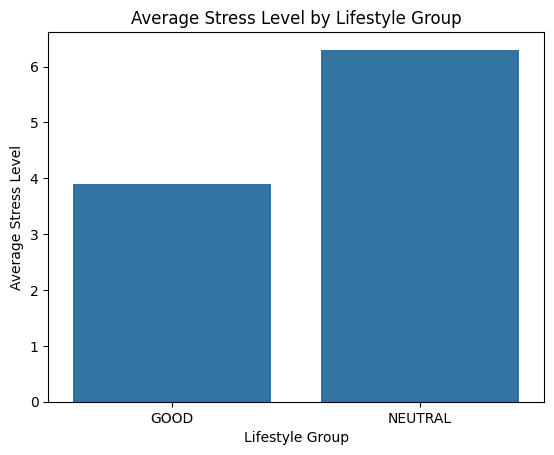

In [35]:
# Plotting the average stress level for each lifestyle group
sns.barplot(x=lifestyle_stress.index, y=lifestyle_stress.values)
plt.xlabel('Lifestyle Group')
plt.ylabel('Average Stress Level')
plt.title('Average Stress Level by Lifestyle Group')
plt.show()


**Clustering Analysis (Clustering Based on Groupings)**

With the groupings and other features, you can use clustering algorithms like KMeans, Agglomerative, or even DBSCAN to cluster individuals with similar characteristics.

KMeans Clustering:

In [36]:
# Select columns for clustering (e.g., physical activity, sleep, stress level, heart rate)
features = df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm']]
features = features.dropna()  # Drop rows with missing values

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering (choose 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Show the cluster assignments
print(df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm', 'cluster']].head())


   level_of_physical_activity_minutes_per_day  duration_of_sleep_hours  \
0                                          30                      7.5   
1                                          45                      6.8   
2                                          15                      8.2   
3                                          60                      7.0   
4                                          10                      5.5   

   level_of_stress_scale_110  heart_rate_bpm  cluster  
0                          5              72        2  
1                          3              75        1  
2                          8              68        2  
3                          4              70        1  
4                          9              80        0  


**Predictive Modeling (Classification or Regression)**

You can build predictive models to predict specific outcomes, such as predicting the mood_output based on the features, or predicting stress levels based on other health factors.

Example - mood_output Prediction (Classification):

Let's say you want to predict the mood_output using features like stress level, sleep duration, and physical activity. You could apply a classification model (e.g., Random Forest, Logistic Regression).

In [37]:
# Prepare the data (assuming 'mood_output' is the target variable)
X = df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm']]
y = df['mood_output']

# Drop rows with missing values in target or features
X = X.dropna()
y = y.loc[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       Happy       1.00      1.00      1.00        45
     Neutral       1.00      1.00      1.00        43
         Sad       1.00      1.00      1.00        60

    accuracy                           1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



**Visualization of Groupings and Health Indicators**

Visualizing the different groups and their health indicators can be insightful, especially to spot patterns and trends.

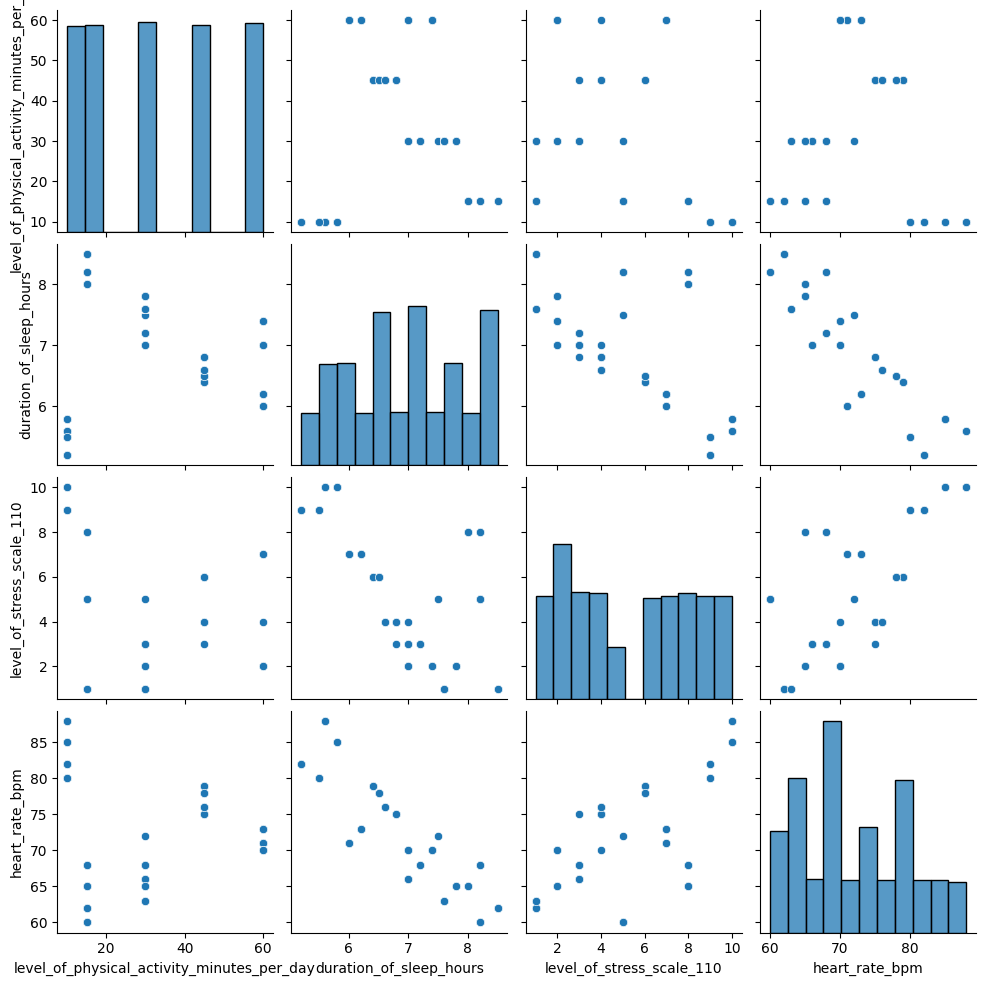

In [38]:
# Pairplot to check the relationships between selected features (e.g., stress, sleep, activity)
sns.pairplot(df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm']])
plt.show()

**Convert Mood to Numeric and Calculate Mean**

In [39]:
# Map mood values to numeric
mood_mapping = {'Happy': 1, 'Neutral': 0, 'Sad': -1}
df['mood_output_numeric'] = df['mood_output'].map(mood_mapping)

# Group by lifestyle and calculate the average mood (numeric)
lifestyle_mood_avg = df.groupby('lifestyle_grouping')['mood_output_numeric'].mean()

# Display the result
print(lifestyle_mood_avg)


lifestyle_grouping
GOOD       0.244068
NEUTRAL   -0.323529
Name: mood_output_numeric, dtype: float64


**Summary Stats for Categorical Columns**

In [40]:
# Get value counts of mood_output by lifestyle group
lifestyle_mood_counts = df.groupby('lifestyle_grouping')['mood_output'].value_counts()

print(lifestyle_mood_counts)


lifestyle_grouping  mood_output
GOOD                Happy          147
                    Sad             75
                    Neutral         73
NEUTRAL             Sad            219
                    Neutral        147
                    Happy           76
Name: count, dtype: int64


In [41]:
# Load the CSV file
df = pd.read_csv('processed_wellness_data.csv')

# Display the first few rows
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'processed_wellness_data.csv'

Column Names:
 ['duration_of_sleep_hours', 'level_of_physical_activity_minutes_per_day', 'level_of_stress_scale_110', 'bmi_category', 'heart_rate_bpm', 'systolic_and_diastolic_blood_pressure', 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'level_of_workload_scale_110', 'quality_or_frequency_of_social_interactions', 'activities_for_mental_health_such_as_therapy_sessions_or_meditation', 'environmental_aspects_such_as_weather_and_air_quality', 'lifestyle_decisions_such_as_drinking_and_smoking', 'additional_health_indicators_eg_water_levels_steps', 'mood_output', 'extracted_steps', 'mood_output_encoded', 'demographic_health_grouping', 'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping', 'activity_level_grouping', 'stress_profile_grouping', 'workload_profile_grouping', 'social_wellness_grouping']

Value Counts for Categorical Columns:

bmi_category:
bmi_category
Normal         297
Overweight     147
Underweight    147
Obese          146
Name: count, dtype: int64

sys

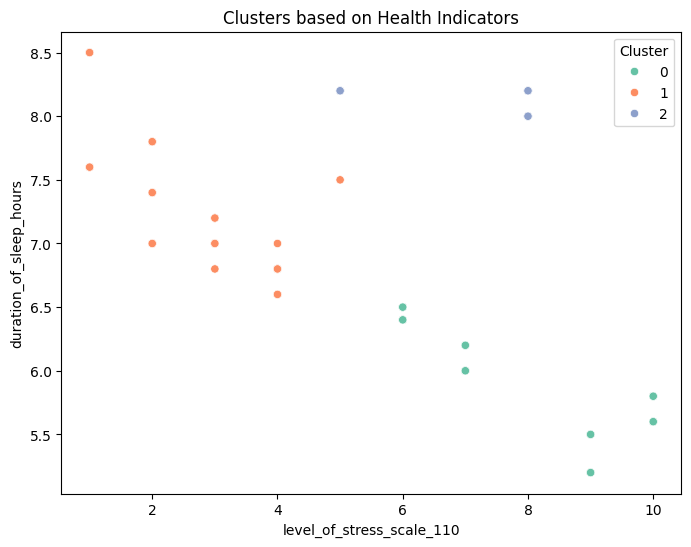


Classification Report for Mood Prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        60

    accuracy                           1.00       148
   macro avg       1.00      1.00      1.00       148
weighted avg       1.00      1.00      1.00       148



In [ ]:
# Preview column names
print("Column Names:\n", df.columns.tolist())

# Clean column names
df.columns = df.columns.str.strip()

# Value Counts for Categorical Columns
cat_cols = df.select_dtypes(include=['object']).columns
print("\nValue Counts for Categorical Columns:")
for col in cat_cols:
    print(f"\n{col}:\n{df[col].value_counts()}")

# Convert Mood to Numeric and Summary Stats for Categorical Columns
if 'mood_output' in df.columns:
    df['Mood_Numeric'] = LabelEncoder().fit_transform(df['mood_output'])

print("\nSummary Stats for Categorical Columns:")
print(df.describe(include='object'))

# Mean Mood by Groupings
group_cols = ['gender', 'age_group']
group_cols = [col for col in group_cols if col in df.columns]  # ensure they exist

if 'Mood_Numeric' in df.columns and group_cols:
    print("\nMean Mood by Groupings:")
    print(df.groupby(group_cols)['Mood_Numeric'].mean())

# Analyze Relationships Between Groupings
print("\nGroup Sizes:")
if group_cols:
    print(df.groupby(group_cols).size())

# Clustering Analysis
features_for_clustering = ['level_of_stress_scale_110', 'duration_of_sleep_hours', 'quality_of_sleep_110']
features_for_clustering = [col for col in features_for_clustering if col in df.columns]

if features_for_clustering:
    X_scaled = StandardScaler().fit_transform(df[features_for_clustering].dropna())

    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    print("\nCluster Counts:")
    print(df['Cluster'].value_counts())

    # Visualize clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[features_for_clustering[0]], y=df[features_for_clustering[1]], hue=df['Cluster'], palette='Set2')
    plt.title('Clusters based on Health Indicators')
    plt.show()

# Predictive Modeling: Mood Output Prediction
model_features = ['level_of_stress_scale_110', 'duration_of_sleep_hours', 'quality_of_sleep_110']
model_features = [col for col in model_features if col in df.columns]
if 'Mood_Numeric' in df.columns and all(col in df.columns for col in model_features):
    X = df[model_features]
    y = df['Mood_Numeric']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("\nClassification Report for Mood Prediction:")
    print(classification_report(y_test, y_pred))
